## FAIRNESS BY REGULARIZATION

Here we will see how we can use the popular variance reduction technique in machine learning model to get a fair trained classifier. We will be using the [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult) for our demonstration purpose.

### IMPORTNG THE NECESSARY LIBRARIES

We will be using the open-source [AIF360](https://github.com/Trusted-AI/AIF360) package to use several fairness based metrics.

In [1]:
import numpy as np
np.set_printoptions(suppress = True)
import pandas as pd

import matplotlib.pyplot as plt

# Importing the Dataset
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.metrics.utils import compute_boolean_conditioning_vector
from common_utils import compute_metrics

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

### DATASET

In [2]:
priv_group = [{'sex':1}]
unpriv_group = [{'sex':0}]

In [3]:
data_adult = load_preproc_data_adult(['sex'])

### FAIRNESS BASED REGULARIZED CLASSIFIER

Here we will fit a regularized logistic regression classifier using different regularization terms for each trained model, to compare the results in terms of accuracy and fairness levels achieved by the model.

#### - EQUALISED ODDS REGULARIZATION

- **METHOD**

Here we will try to achieve a classifier with equalized odds using a regularization term in the loss function which has difference in the values of FPR and FNR for both the classes as shown below:

$$Loss(\theta;G,X)\ =\ -ll(\theta;G,X) + C_1|FPR(G=f)-FPR(G=m)|\\ + C_2|FNR(G=f)-FNR(G=m)| + \frac{1}{2}C_3||\theta||_2^2$$
where, 
$$ll(\theta;G,X) = \sum_{i=1}^n y_i\log(S(x_i^T.\theta))+(1-y_i)\log(1-S(x_i^T.\theta))\\ S(x) = \frac{1}{1+e^{-x}}$$
and $\theta$ represents the weights and biases of the model and $G,X$ is the given data.

We want to find the optimal value of $\theta^*$ such that,
$\DeclareMathOperator*{\argmin}{arg\,min}$
$$\theta^* = \argmin_\theta Loss(\theta;G,X)$$

To solve this above optimization problem, we use gradient descent, starting with an initial value of $\theta_0$, we update the weights and biases as follows,
$$\theta^{n+1} = \theta^{n} - lr\cdot \frac{\partial Loss(\theta;G,X)}{\partial \theta}$$
where, $lr$ is the learning rate.

We will use the common variant of the gradient descent, Stochastic Gradient Descent.

To train our model, we will split our data into 2 parts i.e. training data and a test data

In [85]:
dset_raw_trn, dset_raw_tst = data_adult.split([0.7], shuffle=True)

In [96]:
dset_trn_pred = dset_raw_trn.copy(deepcopy=True)

Taking a look at the fairness metrics for the test data and the proportion of protected group and labels, we get:

In [87]:
def plot_prop_prtced_grp_lab(data, title="", figsize=(10,8)):
    feature_idx = np.where(np.array(data.feature_names) == data.protected_attribute_names[0])[0][0]
    n_p_fav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.privileged_protected_attributes[0],data.labels == data.favorable_label) == True)[0])
    n_unp_fav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.unprivileged_protected_attributes[0],data.labels == data.favorable_label) == True)[0])
    n_p_unfav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.privileged_protected_attributes[0],data.labels == data.unfavorable_label) == True)[0])
    n_unp_unfav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.unprivileged_protected_attributes[0],data.labels == data.unfavorable_label) == True)[0])
    plt.figure(figsize=figsize)
    xlocs = [i for i in range(4)]
    y = [n_p_fav/(n_p_fav+n_p_unfav), n_unp_fav/(n_unp_fav+n_unp_unfav), n_p_unfav/(n_p_fav+n_p_unfav), n_unp_unfav/(n_unp_fav+n_unp_unfav)]
    plt.bar(['priv grp,fav label','unpriv grp,fav label', 'priv grp,unfav label', 'unpriv grp,unfav label'], y)
    for i, v in enumerate(y):
        plt.text(xlocs[i] - 0.05, v + 0.01, str(round(v,2)))
    plt.title(title)
    plt.show()

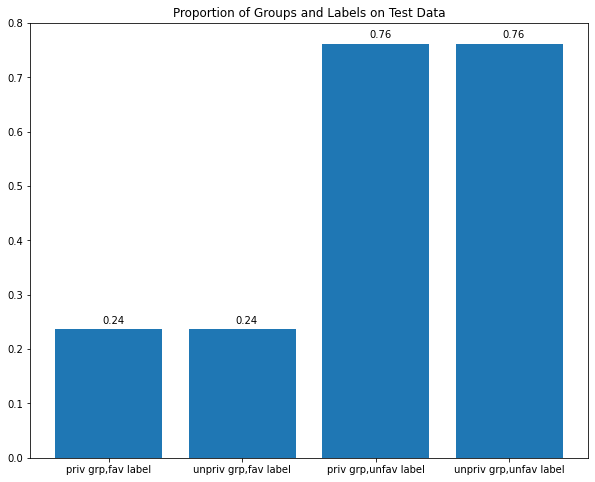

In [88]:
plot_prop_prtced_grp_lab(dset_raw_tst, "Proportion of Groups and Labels on Test Data")

In [89]:
dset_raw_tst_metrics = BinaryLabelDatasetMetric(dset_raw_tst,
                                      unprivileged_groups=unpriv_group,
                                     privileged_groups=priv_group)
print("Statistical Parity Difference:",dset_raw_tst_metrics.statistical_parity_difference())
print("Disparate Impact:",dset_raw_tst_metrics.disparate_impact())
print("Consistency:",dset_raw_tst_metrics.consistency()[0])

Statistical Parity Difference: -0.2011591902342209
Disparate Impact: 0.3404494741177242
Consistency: 0.7363679792534046


We see the training data is quite unfair. The statistical parity difference is significantly below 0 implying the data shows disfavor of the unprivileged group to the favorable outcome. Disparate Impact also shows that.

- **FITTING MODELS**
    - No Fairness Regularized Classifier (Model: $M$)
    - Equalized Odd Regularized Classifier (Model: $M_F$)

Standardizing the training dataset

In [211]:
scaler = StandardScaler()
dset_trn = scaler.fit_transform(dset_raw_trn.features)
y_trn = dset_raw_trn.labels.ravel()
dset_trn = torch.from_numpy(dset_trn).float()
y_trn = torch.from_numpy(y_trn).float()
y_trn = y_trn.view(y_trn.shape[0], 1)

Logistic Regression Class as needed by PyTorch

In [212]:
class Log_Reg(nn.Module):
    def __init__(self, size_in):
        super().__init__()
        self.linear = nn.Linear(size_in, 1)
    def forward(self, x):
        prob_pred = torch.sigmoid(self.linear(x))
        return prob_pred

Below are the two models $M$ and $M_F$ as mentioned before

In [213]:
M = Log_Reg(len(dset_raw_trn.feature_names)) # Non-Fairness Based Regularized Model
M_F = Log_Reg(len(dset_raw_trn.feature_names)) # Fairness Based Regularization Model

In [214]:
num_epochs = 2000 # Number of Epochs
learning_rate = 0.01 # Learning Rate

# Stochastic Gradient Descent Optimizers
optimizer_M = torch.optim.SGD(M.parameters(), lr= learning_rate)
optimizer_M_F = torch.optim.SGD(M_F.parameters(), lr= learning_rate)

# Binary Cross Entropy Loss Functions
criterion = nn.BCELoss()
criterion_f = nn.BCELoss()

In [215]:
# Used Values in the FPR and FNR Score Diffs
trn_data_metric = BinaryLabelDatasetMetric(dset_raw_trn, 
                                           unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)
NA_pos = trn_data_metric.num_positives(True)
NA_neg = trn_data_metric.num_negatives(True)
NB_pos = trn_data_metric.num_positives(False)
NB_neg = trn_data_metric.num_negatives(False)

Defining the fairness based regularization functions

In [216]:
def fnr_score_diff(p_pred):
    FNR_A = torch.sum(p_pred[:,0][np.logical_and((dset_raw_trn.features[:,1] == 1),(dset_raw_trn.labels.ravel() == 1))])
    FNR_B = torch.sum(p_pred[:,0][np.logical_and((dset_raw_trn.features[:,1] == 0),(dset_raw_trn.labels.ravel() == 1))])
    return torch.abs(-FNR_A/NA_pos + FNR_B/NB_pos)

def fpr_score_diff(p_pred):
    FPR_A = torch.sum(p_pred[:,0][np.logical_and((dset_raw_trn.features[:,1] == 1),(dset_raw_trn.labels.ravel() == 0))])
    FPR_B = torch.sum(p_pred[:,0][np.logical_and((dset_raw_trn.features[:,1] == 0),(dset_raw_trn.labels.ravel() == 0))])
    return torch.abs(-FPR_A/NA_neg + FPR_B/NB_neg)

# Fairness Based Regularized Loss
def loss_f(p_pred, y, C1=1, C2=1):
    return criterion_f(p_pred, y_trn) + C1*fpr_score_diff(p_pred) + C2*fnr_score_diff(p_pred)

Training the non-fairness regularized Model $M$

epoch: 200, loss = 0.5680
epoch: 400, loss = 0.4984
epoch: 600, loss = 0.4680
epoch: 800, loss = 0.4523
epoch: 1000, loss = 0.4433
epoch: 1200, loss = 0.4376
epoch: 1400, loss = 0.4339
epoch: 1600, loss = 0.4314
epoch: 1800, loss = 0.4295
epoch: 2000, loss = 0.4282


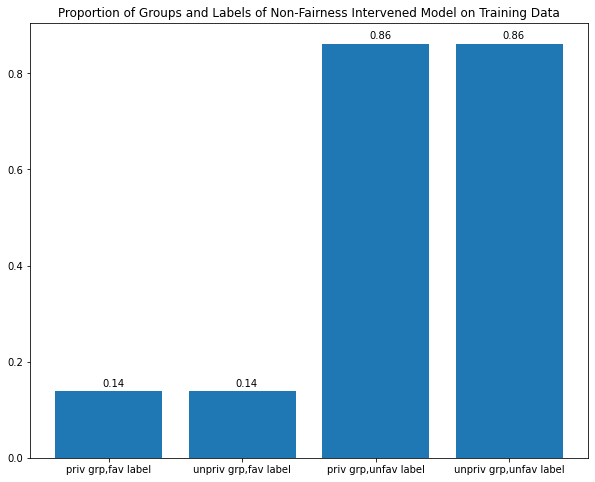

Accuracy: 0.8040012869636433
Predictive Parity Difference: -0.6591823766151239
FNR Difference: 0.4481566820276498
FPR Difference: -0.10084612973989344
Accuracy Difference: -0.12600544053524831
Statistical Parity Difference: -0.20616620813135944
Disparate Impact: 0.0
Consistency: 0.7117844920881018


In [217]:
# Training M
for epoch in range(num_epochs):
    p_pred = M(dset_trn)
    loss= criterion(p_pred, y_trn)
    
    loss.backward()
    optimizer_M.step()
    
    optimizer_M.zero_grad()
    
    if (epoch+1) % 200== 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
        
with torch.no_grad():
    dset_trn_pred.labels = (p_pred > 0.5).numpy().astype(float)
    
    mod_metrics = ClassificationMetric(dset_raw_trn, dset_trn_pred,
                                        unprivileged_groups=unpriv_group,
                                        privileged_groups=priv_group)
    print("Accuracy:", mod_metrics.accuracy())
    print("Predictive Parity Difference:", mod_metrics.positive_predictive_value(False)-mod_metrics.positive_predictive_value(True))
    print("FNR Difference:", mod_metrics.false_negative_rate_difference())
    print("FPR Difference:", mod_metrics.false_positive_rate_difference())
    print("Accuracy Difference:", mod_metrics.error_rate_difference())
    print("Statistical Parity Difference:",mod_metrics.statistical_parity_difference())
    print("Disparate Impact:",mod_metrics.disparate_impact())
    print("Consistency:",mod_metrics.consistency()[0])

The above model without any fairness intervention performs very bad in terms of fairness. We have seen this before in the [Adult Dataset Model](Fairness-Definitios-Comparison.ipynb)

Training Fairness Regularized Model $M_F$

In [210]:
# Training M_F
for epoch in range(num_epochs):
    p_pred = M_F(dset_trn)
    
    loss= loss_f(p_pred, y_trn)
    
    loss.backward()
    optimizer_M_F.step()
    
    optimizer_M_F.zero_grad()
    
    if (epoch+1) % 200== 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
        
with torch.no_grad():
    dset_trn_pred.labels = (p_pred > 0.5).numpy().astype(float)
    plot_prop_prtced_grp_lab(dset_trn_pred, "Proportion of Groups and Labels of Fairness Intervened Model on Training Data")
    mod_metrics = ClassificationMetric(dset_raw_trn, dset_trn_pred,
                                        unprivileged_groups=unpriv_group,
                                        privileged_groups=priv_group)
    print("Accuracy:", mod_metrics.accuracy())
    print("Predictive Parity Difference:", mod_metrics.positive_predictive_value(False)-mod_metrics.positive_predictive_value(True))
    print("FNR Difference:", mod_metrics.false_negative_rate_difference())
    print("FPR Difference:", mod_metrics.false_positive_rate_difference())
    print("Accuracy Difference:", mod_metrics.error_rate_difference())
    print("Statistical Parity Difference:",mod_metrics.statistical_parity_difference())
    print("Disparate Impact:",mod_metrics.disparate_impact())
    print("Consistency:",mod_metrics.consistency()[0])

epoch: 200, loss = 0.5626
epoch: 400, loss = 0.5023
epoch: 600, loss = 0.4783
epoch: 800, loss = 0.4660
epoch: 1000, loss = 0.4604
epoch: 1200, loss = 0.4586
epoch: 1400, loss = 0.4546
epoch: 1600, loss = 0.4507
epoch: 1800, loss = 0.4494
epoch: 2000, loss = 0.4506
Accuracy: 0.7874755038170171
Predictive Parity Difference: -0.30635049232887146
FNR Difference: -0.007485279057859784
FPR Difference: 0.0037505784120530905
Accuracy Difference: -0.09950058351127222
Statistical Parity Difference: -0.05328642112351421
Disparate Impact: 0.6953293989245064
Consistency: 0.7117844920881018


We see the fairness regularized model makes the training data much more fairer at a small cost of accuracy.

From the training set performance we see that the model accuracy decreased by 1.3% but this helped us achieve a fairer classifier with very low FNR and FPR values, Predictive Parity Difference also decreased substantially and accuracy difference became nearer to 0.

- **EVALUATING MODELS**

Looking at the fairness metric and proportion histogram of the test set, we see:

In [ ]:
dset_tst_pred = dset_raw_tst.copy(deepcopy=True)
dset_tst = scaler.transform(dset_tst_pred.features)
dset_tst_pred.labels = (M(dset_tst) > 0.5).numpy().astype(float)

In [ ]:
dset_raw_tst_metrics = BinaryLabelDatasetMetric(dset_raw_tst,
                                      unprivileged_groups=unpriv_group,
                                     privileged_groups=priv_group)
print("Statistical Parity Difference:",dset_raw_tst_metrics.statistical_parity_difference())
print("Disparate Impact:",dset_raw_tst_metrics.disparate_impact())
print("Consistency:",dset_raw_tst_metrics.consistency()[0])